In [302]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

import matplotlib.pyplot as plt
import seaborn as sns

In [303]:
train=pd.read_csv('/kaggle/input/daconcard/open/train.csv')
test=pd.read_csv('/kaggle/input/daconcard/open/test.csv')
submit=pd.read_csv('/kaggle/input/daconcard/open/sample_submission.csv')

In [304]:
def datainfo(df):
    return pd.DataFrame([(col,df[col].dtype,df[col].isna().sum(),df[col].nunique(),df[col].unique()[:5]) for col in df.columns],
                       columns=['name','dtype','missing','nunique','values :5'])

In [305]:
datainfo(train)

,name,dtype,missing,nunique,values :5
0,index,int64,0,26457,"[0, 1, 2, 3, 4]"
1,gender,object,0,2,"[F, M]"
2,car,object,0,2,"[N, Y]"
3,reality,object,0,2,"[N, Y]"
4,child_num,int64,0,9,"[0, 1, 2, 3, 4]"
5,income_total,float64,0,249,"[202500.0, 247500.0, 450000.0, 157500.0, 27000..."
6,income_type,object,0,5,"[Commercial associate, Working, State servant,..."
7,edu_type,object,0,5,"[Higher education, Secondary / secondary speci..."
8,family_type,object,0,5,"[Married, Civil marriage, Separated, Single / ..."
9,house_type,object,0,6,"[Municipal apartment, House / apartment, With ..."


In [306]:
datainfo(test)

,name,dtype,missing,nunique,values :5
0,index,int64,0,10000,"[26457, 26458, 26459, 26460, 26461]"
1,gender,object,0,2,"[M, F]"
2,car,object,0,2,"[Y, N]"
3,reality,object,0,2,"[N, Y]"
4,child_num,int64,0,6,"[0, 1, 2, 3, 5]"
5,income_total,float64,0,208,"[112500.0, 135000.0, 69372.0, 225000.0, 126000.0]"
6,income_type,object,0,5,"[Pensioner, State servant, Working, Commercial..."
7,edu_type,object,0,5,"[Secondary / secondary special, Higher educati..."
8,family_type,object,0,5,"[Civil marriage, Married, Single / not married..."
9,house_type,object,0,6,"[House / apartment, With parents, Rented apart..."


In [307]:
datainfo(submit)

,name,dtype,missing,nunique,values :5
0,index,int64,0,10000,"[26457, 26458, 26459, 26460, 26461]"
1,0,int64,0,1,[0]
2,1,int64,0,1,[0]
3,2,int64,0,1,[0]


In [308]:
## 제거 
train=train.drop(['FLAG_MOBIL','index'],axis=1)
test=test.drop(['FLAG_MOBIL','index'],axis=1)

## 중복 확인 및 제거
cols=['gender', 'car', 'reality', 'child_num', 'income_total',
      'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
      'DAYS_EMPLOYED','work_phone', 'phone', 'email',
      'occyp_type', 'family_size']

## 마지막에 입력된 데이터가 바뀌어도 진짜라고 가정. drop 안했을 때 성능 굳
# train=train.drop_duplicates(subset=cols,keep='last')

## 고용일 처리 -> 양수 성능 굳 ? 
# train['DAYS_BIRTH']=train['DAYS_BIRTH']*(-1/365)
# test['DAYS_BIRTH']=test['DAYS_BIRTH']*(-1/365)

# train['DAYS_EMPLOYED']=train['DAYS_EMPLOYED']*(-1/365)
# train.loc[train['DAYS_EMPLOYED']<0,'DAYS_EMPLOYED']=-999
# test['DAYS_EMPLOYED']=test['DAYS_EMPLOYED']*(-1/365)
# test.loc[test['DAYS_EMPLOYED']<0,'DAYS_EMPLOYED']=-999

## 가족수 이상치 나이대로 판별 이상 판단.
train=train[(train['family_size']!=20)&(train['family_size']!=15)]
# 결측값 
train['occyp_type']=train['occyp_type'].fillna('unknown')
test['occyp_type']=test['occyp_type'].fillna('unknown')

In [309]:
## 시도 파생변수 : 성능 더 떨어진다.

# train['family_size']=pd.Categorical(train['family_size'],ordered=True)
# train['child_num']=pd.Categorical(train['child_num'],ordered=True)
# train['begin_month']=pd.Categorical(train['begin_month'],ordered=True)

# test['family_size']=pd.Categorical(test['family_size'],ordered=True)
# test['child_num']=pd.Categorical(test['child_num'],ordered=True)
# test['begin_month']=pd.Categorical(test['begin_month'],ordered=True)

In [310]:
## income과 gender에 따라 차이가 없다.
# sns.catplot(
#     data=train, kind="bar",
#     x="credit", y="income_total", hue="gender",
#     ci="sd", palette="dark", alpha=.6, height=6
# )

## car reality에 따라 income의 차이는 있다.
# sns.catplot(
#     data=train, kind="bar",
#     x="car", y="income_total", hue="reality",
#     ci="sd", palette="dark", alpha=.6, height=6
# )

## car reality도 차이없다. 
# sns.catplot(
#     data=train, kind="bar",
#     x="credit", y="income_total", hue="reality",
#     ci="sd", palette="dark", alpha=.6, height=6
# )

## income_total은 제거 해본다.
# sns.catplot(
#     data=train, kind="bar",
#     x="credit", y="income_total", hue="begin_month",
#     ci="sd", palette="dark", alpha=.6, height=6
# )

In [311]:
## #했을때 비슷.
# train['gender']=train['gender'].apply(lambda x:1 if x=='M' else 0)
# train['car']=train['car'].apply(lambda x:1 if x=='N' else 0)
# train['reality']=train['reality'].apply(lambda x:1 if x=='N' else 0)
# train['work_phone']=train['work_phone'].apply(lambda x:1 if x==0 else 0)
# train['phone']=train['phone'].apply(lambda x:1 if x==0 else 0)
# train['email']=train['email'].apply(lambda x:1 if x==0 else 0)

# test['gender']=test['gender'].apply(lambda x:1 if x=='M' else 0)
# test['car']=test['car'].apply(lambda x:1 if x=='N' else 0)
# test['reality']=test['reality'].apply(lambda x:1 if x=='N' else 0)
# test['work_phone']=test['work_phone'].apply(lambda x:1 if x==0 else 0)
# test['phone']=test['phone'].apply(lambda x:1 if x==0 else 0)
# test['email']=test['email'].apply(lambda x:1 if x==0 else 0)

In [312]:
# tr_cat_dum=pd.get_dummies(train[['income_type','edu_type','family_type','house_type','occyp_type']],drop_first=True)
# ts_cat_dum=pd.get_dummies(test[['income_type','edu_type','family_type','house_type','occyp_type']],drop_first=True)

In [313]:
# train=train.drop(['income_type','edu_type','family_type','house_type','occyp_type'],axis=1)
# test=test.drop(['income_type','edu_type','family_type','house_type','occyp_type'],axis=1)

In [314]:
# train=pd.concat([train,tr_cat_dum],axis=1)
# test=pd.concat([test,ts_cat_dum],axis=1)

In [315]:
## label
## 수가 많아서 이걸로.

# from category_encoders.ordinal import OrdinalEncoder

# oe=OrdinalEncoder(handle_missing=-999)

# oe.fit(train['family#begin'])
# train['family#begin']=oe.transform(train['family#begin'])
# test['family#begin']=oe.transform(test['family#begin'])

In [316]:
## 가설1. 다중공선성
## 가설2. income_total 구분.
train=train.drop(['DAYS_BIRTH','child_num'],axis=1)
test=test.drop(['DAYS_BIRTH','child_num'],axis=1)

train['income_total']=pd.cut(train['income_total'],bins=[0,100000,350000,500000,750000,1000000,2000000],labels=['F','E','D','C','B','A'])
test['income_total']=pd.cut(test['income_total'],bins=[0,100000,350000,500000,750000,1000000,2000000],labels=['F','E','D','C','B','A'])\

In [317]:
train=pd.get_dummies(train,drop_first=True)
test=pd.get_dummies(test,drop_first=True)

In [318]:
train.shape,test.shape

((26453, 50), (10000, 49))

In [319]:
train.head()

,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,gender_M,car_Y,reality_Y,income_total_E,income_total_D,income_total_C,income_total_B,income_total_A,income_type_Pensioner,income_type_State servant,income_type_Student,income_type_Working,edu_type_Higher education,edu_type_Incomplete higher,edu_type_Lower secondary,edu_type_Secondary / secondary special,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents,occyp_type_Cleaning staff,occyp_type_Cooking staff,occyp_type_Core staff,occyp_type_Drivers,occyp_type_HR staff,occyp_type_High skill tech staff,occyp_type_IT staff,occyp_type_Laborers,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unknown
0,-4709,0,0,0,2.0,-6.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-1540,0,0,1,3.0,-5.0,1.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,-4434,0,1,0,2.0,-22.0,2.0,1,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,-2092,0,1,0,2.0,-37.0,0.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-2105,0,0,0,2.0,-26.0,2.0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [297]:
X=train.drop('credit',axis=1)
y=train['credit']

from sklearn.preprocessing import normalize

X=normalize(X,axis=1)
test=normalize(test,axis=1)

In [298]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15,random_state=71,stratify=y)

## xgb

In [299]:
import xgboost as xgb

params={
    'objective':'multi:softprob',
    'random_state':71,
    'n_estimators':1000
}
model=xgb.XGBClassifier(**params)

model.fit(X_train,y_train,
          eval_set=[(X_train, y_train),(X_test,y_test)],
          eval_metric='mlogloss',verbose=True,
          early_stopping_rounds=10)

[0]	validation_0-mlogloss:0.98109	validation_1-mlogloss:0.98277


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:0.91096	validation_1-mlogloss:0.91427
[2]	validation_0-mlogloss:0.86825	validation_1-mlogloss:0.87351
[3]	validation_0-mlogloss:0.84166	validation_1-mlogloss:0.84852
[4]	validation_0-mlogloss:0.82343	validation_1-mlogloss:0.83322
[5]	validation_0-mlogloss:0.80931	validation_1-mlogloss:0.82276
[6]	validation_0-mlogloss:0.79920	validation_1-mlogloss:0.81594
[7]	validation_0-mlogloss:0.79320	validation_1-mlogloss:0.81207
[8]	validation_0-mlogloss:0.78804	validation_1-mlogloss:0.80886
[9]	validation_0-mlogloss:0.78241	validation_1-mlogloss:0.80533
[10]	validation_0-mlogloss:0.77744	validation_1-mlogloss:0.80325
[11]	validation_0-mlogloss:0.77414	validation_1-mlogloss:0.80163
[12]	validation_0-mlogloss:0.77121	validation_1-mlogloss:0.80050
[13]	validation_0-mlogloss:0.76444	validation_1-mlogloss:0.79660
[14]	validation_0-mlogloss:0.76142	validation_1-mlogloss:0.79525
[15]	validation_0-mlogloss:0.75753	validation_1-mlogloss:0.79352
[16]	validation_0-mlogloss:0.75473

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=71, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [258]:
pred=pd.DataFrame(model.predict_proba(test))
pred['index']=submit['index']
pred=pred[['index',0,1,2]]
pred.head()

/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


,index,0,1,2
0,26457,0.097651,0.147000,0.755348
1,26458,0.212147,0.170724,0.617129
2,26459,0.041298,0.078151,0.880551
3,26460,0.082585,0.107102,0.810313
4,26461,0.065525,0.132900,0.801575


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

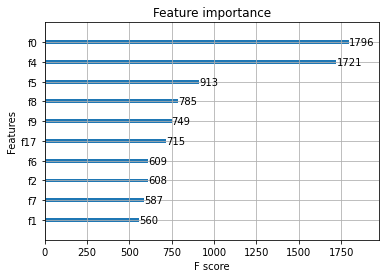

In [320]:
xgb.plot_importance(model,max_num_features=10)

In [321]:
pred.to_csv('20210506_xgboost_multicol2.csv',index=False)

In [ ]:
## income_total 정규성 x -> log 변환 한것을 파생변수로.
## 다른건 몰라도 income_type이 pensioner인 사람들이 DAYS_BIRTH가 오래됐다. 
## -> DAYS_BIRTH는 -7500정도에서 -25000정도 사이 나이로 바꿀 필요가 있을까? -> 보류
## edu_type에 따라 income_total과 DAYS_BIRTH는 선형관계가 있다. 
## DAYS_EMPLOYED 양수 값은 고용되지 않은 상태를 의미함 -> 제거 
## family type과 성별에 따라 income_total의 차이가 없다. 
## FLAG_MOBIL 1밖에 없다. -> 제거 
## 중복값 제거
## family_size child_num 상관관계 -> 제거,income_total income_total_log 제거 그 외 그냥 둔다.

sns.jointplot(data=train, x="family_size", y="begin_month", hue="house_type")
# sns.displot(data=train, x="income_total", col="DAYS_BIRTH", kde=True)
# sns.relplot(data=train,x='income_total',y='DAYS_BIRTH',hue='edu_tpe')

In [ ]:
## 연속형 - 연속
sns.relplot(
    data=train,
    x="income_total", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

sns.lmplot(data=tips, x="total_bill", y="tip", col="time", hue="smoker")
sns.displot(data=tips, x="total_bill", col="time", kde=True)
sns.jointplot(data=penguins, x="flipper_length_mm", y="bill_length_mm", hue="species")

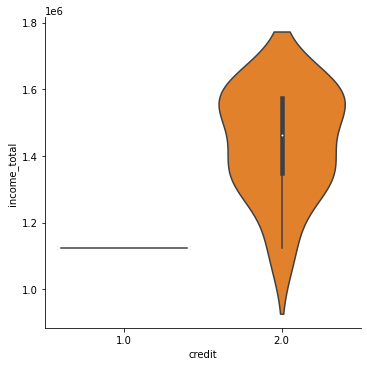

In [66]:
sns.catplot(data=train[train['income_total']>=],kind='violin',x='credit',y='income_total')

In [ ]:
sns.catplot(data=train, kind="violin", x="gender", y="income_total_log", hue="family_type",split=False)

In [ ]:
## 범주 - 연속
sns.catplot(data=tips, kind="swarm", x="day", y="total_bill", hue="smoker",split=True)